# Digit recognizer with Pytorch
### Nguyen Dang Minh, PhD

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import rcParams
import random
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from sklearn.metrics import accuracy_score
from clr_callback import *
import time

import gc

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
from torch.autograd import Variable
import torchsample as ts
torch.set_default_tensor_type('torch.DoubleTensor')

rcParams['font.size']=14
random.seed(1)

import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.


In [2]:
# MODELS PARAMETERS
batch_size = 512
epochs = 20

# Data preparation

### Importing data

In [3]:
# Import data
dataset_orig = pd.read_csv('Data/train.csv')
select_idx = random.sample(range(0,len(dataset_orig)), 2200)
X_orig = dataset_orig.iloc[:,1:].values
Y_orig = dataset_orig.iloc[:,0:1].values

In [4]:
# Reshape and normalize
X_train, X_test, y_train, y_test = train_test_split(X_orig, Y_orig, test_size=0.2)

In [5]:
class DatasetMNist(Dataset):
    def __init__(self, X_set, y_set, transform=None):
        self.dataX = X_set
        self.dataY = y_set
        self.transform = transform
        
    def __len__(self):
        return len(self.dataY)
    
    def __getitem__(self, index):
        image = self.dataX[index,:].astype(np.uint8).reshape((28,28,1))
        label = self.dataY[index,0]
        
        if self.transform is not None:
            image = self.transform(image)
    
        return image, label

### Data loader

In [6]:
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

data_transforms = {
    'train': transforms.Compose([
        transforms.ToPILImage(),
        transforms.RandomRotation(20),
        transforms.RandomResizedCrop(28,scale=(0.8,1.0)),
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
        ]),
    'val': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])
}

train_dataset = DatasetMNist(X_train, y_train, transform=data_transforms['train'])
test_dataset = DatasetMNist(X_test, y_test, transform=data_transforms['val'])

In [7]:
img, lab = train_dataset.__getitem__(0)
print(img.shape)
print(type(img))

torch.Size([1, 28, 28])
<class 'torch.Tensor'>


In [8]:
# Data loader demo
train_loader_demo = DataLoader(train_dataset, batch_size=8, shuffle=False)

In [9]:
train_iter = iter(train_loader_demo)
images, labels = train_iter.next()

print('images shape on batch size = {}'.format(images.size()))
print('labels shape on batch size = {}'.format(labels.size()))

images shape on batch size = torch.Size([8, 1, 28, 28])
labels shape on batch size = torch.Size([8])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


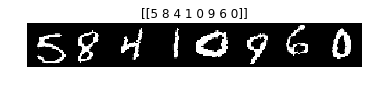

In [10]:
# make grid takes tensor as arg
grid = torchvision.utils.make_grid(images)

plt.imshow(grid.numpy().transpose((1, 2, 0)))
plt.axis('off')
plt.title(labels.reshape(1,-1).numpy());

In [11]:
# Main data loader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## Building model

In [12]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=16, stride=1, kernel_size=5)
        self.cnn2 = nn.Conv2d(in_channels=16, out_channels=32, stride=1, kernel_size=5)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(2,2)
        self.dropout = nn.Dropout(p=0.2)
        self.dropout2d = nn.Dropout2d(p=0.2)
        
        self.fc1 = nn.Linear(32*4*4, 128)
        self.fc2 = nn.Linear(128,64)
        self.out = nn.Linear(64,10)
        
    def forward(self,x):
        x = self.cnn1(x)
        x = self.relu(x)
        x = self.dropout2d(x)
        x = self.maxpool(x)
        
        x = self.cnn2(x)
        x = self.relu(x)
        x = self.dropout2d(x)
        x = self.maxpool(x)
        
        x = x.view(x.size(0),-1)
        x = self.fc1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.dropout(x)
        x = self.out(x)
        
        return x

In [13]:
model = CNN()
model = model.float()
print(model)

CNN(
  (cnn1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
  (cnn2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (relu): ReLU()
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.2)
  (dropout2d): Dropout2d(p=0.2)
  (fc1): Linear(in_features=512, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (out): Linear(in_features=64, out_features=10, bias=True)
)


In [14]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.002)

## Training model

In [15]:
def train_model(model, decay, criterion, train_loader, test_loader, optimizer, num_epochs):
    train_loss = []
    test_loss = []
    train_accuracy = []
    test_accuracy = []
    total_train = len(train_loader.dataset)
    total_test = len(test_loader.dataset)
    
    for epoch in range(num_epochs):
        correct = 0
        running_loss = 0
        
        # Decay learning rate
        if (decay==True):
            for param in optimizer.param_groups:
                LR = param['lr']*0.99
                param['lr'] = np.max(param['lr'], 0.001)
        
        # Training
        model.train()
        for images, labels in train_loader:
            train = Variable(images)
            labels = Variable(labels)

            optimizer.zero_grad()
            output = model(train)
            loss = criterion(output, labels)
            prediction = np.argmax(output.data,1)
            correct += np.equal(prediction, labels.data).sum()
            running_loss += loss.item()
            
            loss.backward()
            optimizer.step()
            del images, labels
            
        correct_train = correct.data.numpy()/total_train
        loss_train = running_loss/total_train
        train_accuracy.append(correct_train)
        train_loss.append(loss_train)

        # Testing
        with torch.no_grad():
            model.eval()
            correct = 0
            running_loss = 0
            total = 0
            
            for images, labels in test_loader:
                test = Variable(images)
                labels = Variable(labels)
                output = model(test)
                loss = criterion(output, labels)
                prediction = np.argmax(output.data,1)
                correct += np.equal(prediction, labels.data).sum()
                running_loss += loss.item()
                total += labels.size(0)
                
            correct_test = correct.data.numpy()/total_test
            loss_test = running_loss/total_test
            test_accuracy.append(correct_test)
            test_loss.append(loss_test)
        
        # Prin result
        print("Epoch: {}/{} -- ".format(epoch+1,num_epochs),
              "Training accuracy: {:.5f} -- ".format(correct_train),
              "Test accuracy: {:.5f}".format(correct_test))
       
    dictionary = {'train_loss': train_loss,
                  'train_accuracy': train_accuracy,
                  'test_loss': test_loss,
                  'test_accuracy': test_accuracy}
    return model, dictionary

In [16]:
model_out, result_dict = train_model(model, 
                                    decay=False, 
                                    criterion=criterion, 
                                    train_loader=train_loader,
                                    test_loader=test_loader,
                                    optimizer=optimizer,
                                    num_epochs=epochs)

Epoch: 1/20 --  Training accuracy: 0.75226 --  Test accuracy: 0.95417
Epoch: 2/20 --  Training accuracy: 0.91122 --  Test accuracy: 0.97619
Epoch: 3/20 --  Training accuracy: 0.92815 --  Test accuracy: 0.97905
Epoch: 4/20 --  Training accuracy: 0.93827 --  Test accuracy: 0.97833
Epoch: 5/20 --  Training accuracy: 0.94104 --  Test accuracy: 0.98095
Epoch: 6/20 --  Training accuracy: 0.94307 --  Test accuracy: 0.98226
Epoch: 7/20 --  Training accuracy: 0.94920 --  Test accuracy: 0.98214
Epoch: 8/20 --  Training accuracy: 0.94836 --  Test accuracy: 0.98464
Epoch: 9/20 --  Training accuracy: 0.95092 --  Test accuracy: 0.98524
Epoch: 10/20 --  Training accuracy: 0.95318 --  Test accuracy: 0.98274
Epoch: 11/20 --  Training accuracy: 0.95461 --  Test accuracy: 0.98607
Epoch: 12/20 --  Training accuracy: 0.95315 --  Test accuracy: 0.98595
Epoch: 13/20 --  Training accuracy: 0.95607 --  Test accuracy: 0.98619
Epoch: 14/20 --  Training accuracy: 0.95592 --  Test accuracy: 0.98726
Epoch: 15/20 --

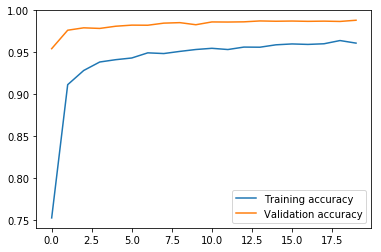

In [17]:
plt.plot(result_dict['train_accuracy'], label='Training accuracy')
plt.plot(result_dict['test_accuracy'], label='Validation accuracy')
plt.legend(loc='best')